# Importing the required libraries

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils



import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


Plots functions

In [39]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.title("Loss Vs number of Iterations")
    plt.show()

## dataset creation for the model based on our need

In [40]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        # if you want to see the grayscale visualization: then remove the comments:
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


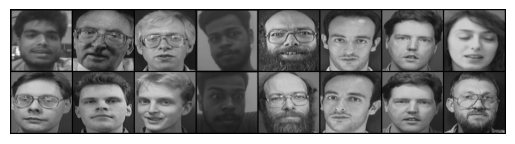

[1. 1. 1. 0. 0. 0. 0. 1.]


In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="C:/Users/aryab/Documents/Study/InnovLab/data_preparation/data/training")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transformation)


# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [42]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.Convolution_layers= nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),#  JUST CHANGED SO THAT WE CAN USE THE MODEL FOR THE COLOUR IMAGES.
            nn.ReLU(inplace=True),

            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.Convolution_layers(x)
        flattened_output = output.view(output.size()[0], -1)#
        output = self.fully_connected_layers(flattened_output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [43]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Loading the dataset for training 

In [44]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,shuffle=True,batch_size=16)

In [45]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'



net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)


# Training model

Epoch number 0
 Current loss 1.9954628944396973



Epoch number 0
 Current loss 0.3617548644542694

Epoch number 0
 Current loss 0.9709203839302063

Epoch number 0
 Current loss 0.32092028856277466

Epoch number 1
 Current loss 1.088829517364502

Epoch number 1
 Current loss 0.48909586668014526

Epoch number 1
 Current loss 0.7661451101303101

Epoch number 1
 Current loss 0.5753865242004395

Epoch number 2
 Current loss 0.3051029145717621

Epoch number 2
 Current loss 0.6055557131767273

Epoch number 2
 Current loss 1.222575068473816

Epoch number 2
 Current loss 0.4162290394306183

Epoch number 3
 Current loss 1.1131888628005981

Epoch number 3
 Current loss 0.2870239019393921

Epoch number 3
 Current loss 0.6575619578361511

Epoch number 3
 Current loss 0.2818334996700287

Epoch number 4
 Current loss 0.7019490599632263

Epoch number 4
 Current loss 0.5604665875434875

Epoch number 4
 Current loss 1.1477710008621216

Epoch number 4
 Current loss 0.599903404712677

Epoch number 5
 Current loss 0.5391809940338135

Epoch number 5
 Curre

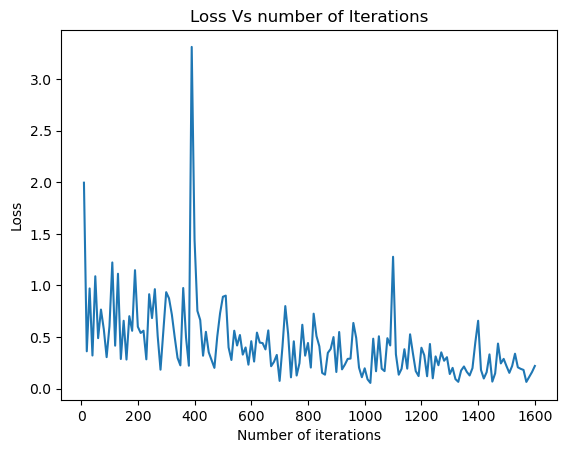

In [46]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(40):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

Save the model

In [ ]:
# Saving the model to the computer vision project::: CPU one

torch.save(net.state_dict(), "C:/Users/aryab/Documents/Study/InnovLab/models/siamese_face_cpu.pt")


## Load the models

In [ ]:
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load(r"C:/Users/aryab/Documents/Study/InnovLab/data_preparation/data/training/models/siamese_face_cpu.pt"))
model.eval()



SiameseNetwork(
  (Convolution_layers): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fully_connected_layers): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [49]:
# # Locate the test dataset and load it into the SiameseNetworkDataset
# folder_dataset_test = datasets.ImageFolder(root="/content/drive/MyDrive/data/faces/testing")
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transformation)
# test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# # Grab one image that we are going to test
# dataiter = iter(test_dataloader)
# x0, _, _ = next(dataiter)

# for i in range(15):
#     # Iterate over 10 images and test them with the first image (x0)
#     _, x1, label2 = next(dataiter)

#     # Concatenate the two images together
#     concatenated = torch.cat((x0, x1), 0)
#     output1, output2 = model(x0.to(device), x1.to(device))# here the model returns the output: of neural net:
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')


#importing the ImageNameDataset: to load the dataset

In [50]:
# from dataset_for_siamese import ImageNameDataset

## Loading the saved model to run

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate the SiameseNetwork
# siamese_model = SiameseNetwork()

# # Load the pre-trained weights if available
# # Adjust the path accordingly based on where your model weights are saved
# model_weights_path = "C:/Users/aryab/Documents/Study/InnovLab/models/siamese_face_cpu.pt"
# siamese_model.load_state_dict(torch.load(model_weights_path, map_location=device))

# # Set the model to evaluation mode
# siamese_model.eval()

# # Move the model to the appropriate device (CPU or GPU)
# siamese_model.to(device)

In [ ]:
# # creating the Known dataset for the model:
# # folder_dataset = datasets.ImageFolder(root="C:/Users/aryab/Documents/Study/InnovLab/data_preparation/data/known_images")

# # Resize the images and transform to tensors
# transformation = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
# root1="C:/Users/aryab/Documents/Study/InnovLab/data_preparation/data/known_images"
# # Initialize the network
# known_dataset= ImageNameDataset(folder_path=root1,transform=transformation)

# # creating the detected datasets for the model:
# # unknown_folder=datasets.ImageFolder(root="C:/Users/aryab/Documents/Study/InnovLab/data_preparation/data/detected_faces")
# root2="C:/Users/aryab/Documents/Study/InnovLab/data_preparation/data/detected_faces"
# unknown_dataset=ImageNameDataset(folder_path=root2,transform=transformation)

# test_dataloader1 = DataLoader(known_dataset,  batch_size=1, shuffle=True)
# test_dataloader2=DataLoader(unknown_dataset,  batch_size=1, shuffle=True)


In [53]:

# # Grab one image that we are going to test
# dataiter1 = iter(test_dataloader1)
# dataiter2=iter(test_dataloader2)
# names=[]
# images=[]
# distance=[]# this is to store the values for all the predictors:
# ## NOW WE ARE ONLY WORKING ON THE ONE IMAGES: LET'S WHAT IF WE GET THE MULTIPLE IMAGES: LATER

# for data1 in test_dataloader1: # for each image in the database: we test the detected image
#     x0,label=data1
#     # we will find the dissimialritty
#     names.append(label[0])
#     images.append(x0)
#     # dist=[]
#     for data2 in test_dataloader2:
#         x1,_=data2 # from the above we will work 
#         # Concatenate the two images together
#         concatenated = torch.cat((x0, x1), 0)
#         output1, output2 = siamese_model(x0.to(device), x1.to(device))# here the model returns the output: of neural net:
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         distance.append(euclidean_distance.item())
#         # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
#     # if dist :
#     #     distance.append(dist)
# ## Now find the minimum distance among all the distances:
# min_element = min(distance)

# # Find the index of the minimum element
# min_index = distance.index(min_element)

# known_image=images[min_index]
# # known_image=torch.tensor(known_image)
# # Now convert this known image as the tensor image as the 
# image_name=names[min_index]

# data_iter = iter(test_dataloader2)
# unknown_image, _ = next(data_iter)
# concatenated = torch.cat((known_image, unknown_image), 0)
# imshow(torchvision.utils.make_grid(concatenated), f'Name:{image_name} Dissimilarity: {min_element:.2f}')

Perforamce Metrics 

In [ ]:
# Load the training dataset
test_folder_dataset = datasets.ImageFolder(root="C:/Users/aryab/Documents/Study/InnovLab/data_preparation/data/testing")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

# Initialize the network
test_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_folder_dataset ,transform=transformation)
# Load the training dataset
test_dataloader = DataLoader(test_siamese_dataset,shuffle=True,batch_size=1)

In [55]:


# Define a threshold for distance (experiment to find a good value)
threshold = 0.5 

correct = 0
total = 0

# Iterate through the test data
for i, (img0, img1, label) in enumerate(test_dataloader, 0):

  # Send the images and labels to device (if using GPU)
  img0, img1, label = img0.to(device), img1.to(device), label.to(device)

  # Pass in the two images into the network and obtain two outputs
  output1, output2 = model(img0, img1)

  # Calculate the euclidean distance
  euclidean_distance = F.pairwise_distance(output1, output2)

  # Check if prediction is correct based on label and distance
  predicted_same = euclidean_distance.item() < threshold
  if predicted_same == (label[0] == "same"):  # Check if label and prediction match
    correct += 1
  total += 1

  # Print some information for each batch
  print(f"Batch: {i+1}/{len(test_dataloader)} - Dissimilarity: {euclidean_distance.item():.2f} - Label: {label[0]} - Prediction: {'Same' if predicted_same else 'Different'}")

# Calculate and print the accuracy
accuracy = correct / total * 100
print(f"\nAccuracy: {accuracy:.2f}%")

# Calculate False Positive Rate (FPR) based on accuracy
false_positives = total - correct
false_positive_rate = (false_positives / total) * 100
print(f"False Positive Rate: {false_positive_rate:.2f}%")

# FNR calculation might require separate validation data with known ground truth
# You can comment out this section if not available
# Assuming you have the number of actual same person pairs in the test data
# number_of_same_pairs =10 # (number of actual same person pairs)
# false_negatives = number_of_same_pairs - correct
# false_negative_rate = (false_negatives / number_of_same_pairs) * 100
# print(f"False Negative Rate: {false_negative_rate:.2f}%")

Batch: 1/30 - Dissimilarity: 0.73 - Label: tensor([0.]) - Prediction: Different
Batch: 2/30 - Dissimilarity: 1.09 - Label: tensor([1.]) - Prediction: Different
Batch: 3/30 - Dissimilarity: 2.90 - Label: tensor([1.]) - Prediction: Different
Batch: 4/30 - Dissimilarity: 0.50 - Label: tensor([0.]) - Prediction: Same
Batch: 5/30 - Dissimilarity: 0.35 - Label: tensor([0.]) - Prediction: Same
Batch: 6/30 - Dissimilarity: 0.23 - Label: tensor([0.]) - Prediction: Same
Batch: 7/30 - Dissimilarity: 3.09 - Label: tensor([1.]) - Prediction: Different
Batch: 8/30 - Dissimilarity: 3.59 - Label: tensor([1.]) - Prediction: Different
Batch: 9/30 - Dissimilarity: 1.46 - Label: tensor([1.]) - Prediction: Different
Batch: 10/30 - Dissimilarity: 2.90 - Label: tensor([1.]) - Prediction: Different
Batch: 11/30 - Dissimilarity: 3.20 - Label: tensor([1.]) - Prediction: Different
Batch: 12/30 - Dissimilarity: 0.16 - Label: tensor([0.]) - Prediction: Same
Batch: 13/30 - Dissimilarity: 0.00 - Label: tensor([0.]) 